# Acquiring concert data

In [44]:
import urllib
import requests
import json
import pandas as pd
import os
from pytrends.request import TrendReq
import matplotlib
from matplotlib import pyplot as plt
import tweepy as tw
import csv
import preprocessor.api as p
from preprocessor.api import clean, tokenize, parse, set_options
import pandas as pd
import re #regular expression
from textblob import TextBlob
import string
import nltk
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
pytrend = TrendReq(hl='en-US', tz=360)

[nltk_data] Downloading package punkt to /Users/kexinsu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
client_ID = 'MjA3NTUxNzd8MTU4MTgwMDk3NC4wNw'
client_SECRET = 'cb752387389554e03787a6906c02e5e49ce2121ae05fbb0d8a1a4e6ba01e8bb7'
url = 'https://api.seatgeek.com/2/events/?' + 'client_id=' + client_ID
r = requests.get(url)

In [ ]:
#r.json()['meta']
data = r.json()
data['events'][1]['score']

In [ ]:
url = 'https://api.seatgeek.com/2/events?type=concert\
&venue.state=NY&client_id=' + client_ID + \
'&per_page=5&format=json'
r = requests.get(url)
events = r.json()
events['meta'] 

In [ ]:
def ny_events(type_concert):

    # This is where all of our data will be at the end
    parsed_events= []
    client_ID = 'MjA3NTUxNzd8MTU4MTgwMDk3NC4wNw'
    # Range: since there are 2783 events, start from page 1 and loop 3 pages (1000 events each)
    for i in range(1, 4):
        url = 'https://api.seatgeek.com/2/events?type='+type_concert+\
        '&venue.state=NY&client_id=' + client_ID + \
        '&per_page=1000&format=json&page='+str(i) # Create URL again with looped page count
        r = requests.get(url)
        events = r.json()

        # Loop through events on each page
        for j in range(1, 1000):

            # 'stats' for ticket info, current events to extract data
            stats = events['events'][j]['stats']
            current_event = {}
            
            # Event Data
            current_event['event_title'] = events['events'][j]['title']
            current_event['type_event'] = events['events'][j]['type']
            current_event['date&time_event'] = events['events'][j]['datetime_local']
            current_event['announce_date'] = events['events'][j]['announce_date']
            current_event['visible_until_utc'] = events['events'][j]['visible_until_utc']
            current_event['event_score'] = events['events'][j]['score']

            # Performer Data
            current_event['performer_name']= events['events'][j]['performers'][0]['name']
            if 'genres' not in events['events'][j]['performers'][0].keys():
                current_event['performer_genre'] = ''
            else:
                current_event['performer_genre'] = events['events'][j]['performers'][0]['genres'][0]['name']

            # Ticket Data
            current_event['ticket_listing_count']= stats['listing_count']
            current_event['average_price']= stats['average_price']
            current_event['median_price']= stats['median_price']
            current_event['lowest_price']= stats['lowest_price']
            current_event['highest_price']= stats['highest_price']
            
            # Venue Data
            current_event['venue_name']= events['events'][j]['venue']['name']
            current_event['venue_city']= events['events'][j]['venue']['city']
            current_event['venue_zipcode']= events['events'][j]['venue']['postal_code']
            current_event['upcoming_events?'] = events['events'][j]['venue']['has_upcoming_events']
            current_event['venue_score'] = events['events'][j]['venue']['score']
            current_event['venue_capacity'] = events['events'][j]['venue']['capacity']

            # Other
            current_event['url'] = events['events'][j]['url']

            #print(range(1,j)) , show the loop is working

            # Events stop at 783
            if i == 3 and j == 440:
                break

            # Add all of this data to our edited events
            parsed_events.append(current_event)

            # Save file
    with open('ny-concerts.json', 'w') as f:
        json.dump(parsed_events, f)
    return parsed_events

In [ ]:
ny_events('concert')
with open('ny-concerts.json', 'r') as f:
    datastore = json.load(f)

# Then I use pandas to convert it
import pandas as pd
df = pd.DataFrame(datastore)
df.to_csv('ny_concerts.csv')

# Collect New Data and Conduct LDA topic modeling

In [ ]:
import webhoseio
webhoseio.config(token="8bec0992-4b9f-4f47-8138-90ff7f432814")
query_params = {
	"q": "Entertainment language:english site_type:news location:(United States)",
	"ts": "1579208540516",
	"sort": "replies_count"
}
output = webhoseio.query("filterWebContent", query_params)
with open('D:/Study/Columbia/term2/6895/Data/675_20170904110837/675_webhose-2015-10-new_20170904110909/news_0000047.json','r',encoding='utf8')as fp:
    json_data=json.load(fp)
json_data

# Concert selection
## Selecting popular genre

In [ ]:
cwd = os.getcwd()
cwd

In [ ]:
cc = pd.read_csv('/Users/kexinsu/Desktop/哥大/6895/ny-concerts.csv')
genre = list(set(cc['performer_genre']))
genre = [i for i in genre if str(i) != 'nan']
genre.remove('Alternative')
i=0
while i <len(genre):
    if genre[i]=='Rnb':
        genre[i] = 'Rhythm and blues'
    elif genre[i]=='Soul':
        genre[i] = 'Soul music'
    elif genre[i]=='Punk':
        genre[i] = 'Punk rock'
    elif genre[i]=='Electronic':
        genre[i] = 'Electronic dance music'
    elif genre[i]=='Latin':
        genre[i] = 'Latin music'
    elif genre[i]=='Indie':
        genre[i] = 'Independent music'
    elif genre[i]=='Country':
        genre[i] = 'Country music'
    elif genre[i]=='Folk':
        genre[i] = 'Folk music'
    elif genre[i]=='Pop':
        genre[i] = 'Pop music'
    elif genre[i]=='Hip-Hop':
        genre[i] = 'Hip hop music'
    i+=1
genre

In [ ]:
!pip install pytrends
#!pip install pytrends --upgrade
#!pip install --upgrade pandas

In [8]:
from pytrends.request import TrendReq
pytrend = TrendReq(hl='en-US', tz=360)
#pytrends.build_payload(genre, cat=0, timeframe='today 5-y', geo='US')

In [36]:
pytrend.build_payload(kw_list=['Music Genre'])
related_topic = pytrend.related_topics()
a = related_topic['Music Genre']['top']
genre=a[['value','topic_title','topic_type']]
genre

,value,topic_title,topic_type
0,100,Genre,Topic
1,99,Music,Topic
2,74,Music genre,Topic
3,4,Rock,Musical genre
4,4,Pop music,Musical genre
5,3,Crossword,Topic
6,3,Musical ensemble,Topic
7,3,Musician,Topic
8,3,Popular music,Musical style
9,3,Artist,Topic


## Select rock singers based on number of recent tweet and tweet polarity

In [3]:
auth = tw.OAuthHandler(
'8Uslx3y5TBcs1BoPGlpPjYzc8', 
'mC9SZZEccIdODx2XUdsXyBlk5kCj18aHoqTftyjiJ2AfCdhGoA')
auth.set_access_token('937889022969597952-2PV3S06eXNylx8DVmEnrU2zlGWO0aby', 
                      '8sHKZU37LpawZEwoGJAALsvPSrbYIsYZmKYKjrEBbvXAB')
api = tw.API(auth, wait_on_rate_limit=True)
search_word = "#Microwave"
tweets = tw.Cursor(api.search,
              q=search_word+ " -filter:retweets",
              lang="en").items(10)

In [2]:
auth = tw.OAuthHandler(
'8Uslx3y5TBcs1BoPGlpPjYzc8', 
'mC9SZZEccIdODx2XUdsXyBlk5kCj18aHoqTftyjiJ2AfCdhGoA')
auth.set_access_token('937889022969597952-2PV3S06eXNylx8DVmEnrU2zlGWO0aby', 
                      '8sHKZU37LpawZEwoGJAALsvPSrbYIsYZmKYKjrEBbvXAB')
api = tw.API(auth, wait_on_rate_limit=True)

# Collect tweets
def get_tweet(search_word,tweets):
    csvFile = open(os.path.join('/Users/kexinsu/Desktop/哥大/6895/singer/',search_word+'.csv'), 'a')
    #Use csv Writer
    csvWriter = csv.writer(csvFile)
    for tweet in tweets:
        csvWriter.writerow([tweet.text.encode('utf-8')])   

In [3]:
Singer = pd.read_csv('/Users/kexinsu/Desktop/哥大/6895/ny_concerts.csv')
singer = Singer['performer_name'].tolist()
popular=[]
for s in singer:
    tweets = tw.Cursor(api.search,q=str(s)+ " -filter:retweets",lang="en").items(210)
    print(s)
    if sum(1 for _ in tweets) < 200: continue
    else: 
        popular.append(s)
        get_tweet(s,tweets) 

TheDiscoBiscuits
WalterTrout
PalayeRoyale
12thPlanet
BlackLabelSociety
Microwave
SloppySeconds
PearlJam
VERITE
PussyRiot
Carnifex
Tyr
Subhumans
LordsOfAcid
Cold
H2O
LifeOfAgony
LosAmigosInvisibles
TheEnglishBeat
PopaChubby
TheSlackers
MatthewGood
DamoSuzuki
AlmostQueen
HockeyDad
Tool
TheMummies
Accept
Juice
TheBallroomThieves
LTJBukem
MikelErentxun
GregDulli
AlterBridge
Elder
TheTemptations
RedCityRadio
YaelNaim
MotionlessinWhite
UncleAcid&TheDeadbeats
ChrisDuarte
TheMachine
AcidWitch
LowCutConnie
Snot
A.J.Croce
CircaSurvive
KingBuzzo
TheGoodLife
TheLumineers
Starset
Primus
ScottStapp
FromAutumntoAshes
NanaGrizol
FitForAKing
FreddieMcGregor
Bauhaus
NileRodgers
BuddyGuy
BruceIntheUSA
BreakingBenjamin
SlightlyStoopid
Failure
LongBeachDubAllstars
RageAgainstTheMachine
Thao&theGetDownStayDown
Disturbed
BikiniKill
TheBlackKeys
AmonTobin
D.R.I.
JudasPriest
Nightwish
Front242
TheDirtyKnobs
BrunoMajor
EzraFurman
Everlast


In [4]:
for i in popular:
    tweets = tw.Cursor(api.search,q= i + " -filter:retweets",lang="en").items(300)
    get_tweet(i,tweets)

In [5]:
popular

['PalayeRoyale',
 'Microwave',
 'PearlJam',
 'VERITE',
 'Tyr',
 'Subhumans',
 'Cold',
 'H2O',
 'Tool',
 'Accept',
 'Juice',
 'AlterBridge',
 'Elder',
 'TheTemptations',
 'TheMachine',
 'Snot',
 'TheGoodLife',
 'TheLumineers',
 'Starset',
 'Primus',
 'Bauhaus',
 'NileRodgers',
 'Failure',
 'RageAgainstTheMachine',
 'Disturbed',
 'D.R.I.',
 'JudasPriest',
 'Nightwish',
 'EzraFurman',
 'Everlast']

In [49]:
popular=['PalayeRoyale',
 'Microwave',
 'PearlJam',
 'VERITE',
 'Tyr',
 'Subhumans',
 'Cold',
 'H2O',
 'Tool',
 'Accept',
 'Juice',
 'AlterBridge',
 'Elder',
 'TheTemptations',
 'TheMachine',
 'Snot',
 'TheGoodLife',
 'TheLumineers',
 'Starset',
 'Primus',
 'Bauhaus',
 'NileRodgers',
 'Failure',
 'RageAgainstTheMachine',
 'Disturbed',
 'D.R.I.',
 'JudasPriest',
 'Nightwish',
 'EzraFurman',
 'Everlast']

In [42]:
def clean_tweet(ls):
    s=''
    for i in ls:
        s=s+p.clean(str(i))
    s1=s.replace('"b','')
    s2=s1.replace('b"','')
    s3=re.sub('x[a-z0-9][a-z0-9]','',s2)
    s4=s3.replace('\\n','')
    s5=s4.replace('&amp;','')
    s6=s5.translate(str.maketrans('', '', string.punctuation))
    s_clean=re.sub(' +', ' ',s6 )
    #return(s_clean)
    return (TextBlob(s_clean).sentiment.polarity)
#clean_tweet(mg_ls)

def clean_tweet_single(s):
    s=p.clean(str(s))
    s1=s.replace('"b','')
    s2=s1.replace('b"','')
    s3=re.sub('x[a-z0-9][a-z0-9]','',s2)
    s4=s3.replace('\\n','')
    s5=s4.replace('&amp;','')
    s6=s5.translate(str.maketrans('', '', string.punctuation))
    s_clean=re.sub(' +', ' ',s6 )
    return(s_clean)

In [57]:
def get_singer_List(popular, n):
    pol=[]
    for i in popular:
        df = pd.read_csv('/Users/kexinsu/Desktop/哥大/6895/singer/'+ i +'.csv',header=None)
        df_ls = df.values.tolist()
        pol.append(clean_tweet(df_ls))
    popular=pd.DataFrame(popular)
    pol=pd.DataFrame(pol)

    polar = pd.concat([popular, pol], axis=1, ignore_index=True)

    polar.sort_values(by=[1], inplace=True, ascending=False,ignore_index=True)
    #print(polar[0:5][1])
    final_singer=list()
    i=0
    while i<n:
        sp = re.sub(r"(\w)([A-Z])", r"\1 \2", polar[0][i])
        final_singer.append(sp)
        i+=1
    singer_fin=pd.DataFrame({'Singer Name':final_singer, 'Polarity Score':polar[0:n][1]})
    return(singer_fin)
get_singer_List(popular,6)

,Singer Name,Polarity Score
0,Palaye Royale,0.486007
1,Alter Bridge,0.391436
2,Nile Rodgers,0.323203
3,The Temptations,0.264479
4,Judas Priest,0.234733
5,Starset,0.197671


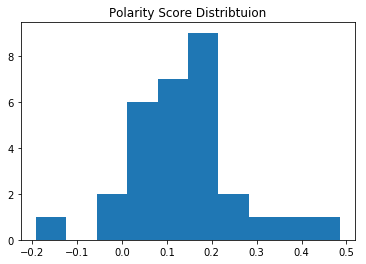

In [59]:
def polarity_plot(popular):
    pol=[]
    for i in popular:
        df = pd.read_csv('/Users/kexinsu/Desktop/哥大/6895/singer/'+ i +'.csv',header=None)
        df_ls = df.values.tolist()
        pol.append(clean_tweet(df_ls))
    popular=pd.DataFrame(popular)
    pol=pd.DataFrame(pol)

    polar = pd.concat([popular, pol], axis=1, ignore_index=True)
    plt.hist(polar[1])
    plt.title('Polarity Score Distribtuion')
    plt.show()

## Finding potential buyers based on tweet polarity and user location

In [32]:
pytrend.build_payload(kw_list=['The Temptations'])
related_topic = pytrend.related_topics()
p = related_topic['The Temptations']['top']
related = p[['topic_title','topic_type']]
print(related)
kg=[]
for i in related.index:
    if ('band' in related['topic_type'][i] or 
        'Band' in related['topic_type'][i] or 
        'Supergroup' in related['topic_type'][i] or i==0):
        kg.append(related['topic_title'][i])
kg
len(kg)

                 topic_title                                topic_type
0            The Temptations                               Vocal group
1                    My Girl  Song by Ronald White and Smokey Robinson
2                    My Girl                   Song by The Temptations
3   The Fighting Temptations                                 2003 film
4                    My Girl                      Song by The Whispers
5                    My Girl      Song by Nereous Joseph and Tenor Fly
6                    My Girl                     Song by Aaron Neville
7            The Temptations                                Miniseries
8                    My Girl                         Song by Sam Milby
9              Otis Williams                         American baritone
10                   My Girl                     Song by Stevie Wonder
11              David Ruffin                           American singer
12                Temptation                                     Topic
13    

1

In [19]:
kg[0]+' OR '+kg[0].replace(" ", "")
for k in kg:
    print(k+' OR '+k.replace(" ", ""))

Nile Rodgers OR NileRodgers
Chic OR Chic
Duran Duran OR DuranDuran


In [36]:
def sl_single(sn):
    pytrend.build_payload(kw_list=[sn])
    related_topic = pytrend.related_topics()
    p = related_topic[sn]['top']
    related = p[['topic_title','topic_type']]
    kg=[]
    for i in related.index:
        if ('band' in related['topic_type'][i] or 
            'Band' in related['topic_type'][i] or 
            'Supergroup' in related['topic_type'][i] or i==0 or
           'inger' in related['topic_type'][i]):
            kg.append(related['topic_title'][i])
    print(kg)
    userid=[]
    name=[]
    screenName=[]
    location=[]
    if (len(kg) > 3):
        n = 200
    else:
        n = 300
    for k in kg:
        search_word = k+' OR '+k.replace(" ", "")
        tweets = tw.Cursor(api.search, q=search_word+ " -filter:retweets", lang="en").items(n)
        for tweet in tweets:
            s=clean_tweet_single(tweet.text)
            if(TextBlob(s).sentiment.polarity > 0):
                if ('New York' in tweet.user.location or 'NY' in tweet.user.location):
                    userid.append(tweet.user.id)
                    name.append(tweet.user.name)
                    screenName.append(tweet.user.screen_name)
                    location.append(tweet.user.location)
                else:
                    pass
            else:
                pass
    userInfo=pd.DataFrame({'Performer':[sn]*len(userid),'UserID':userid,
                       'Name':name,'ScreenName':screenName,'Location':location})
    userInfo.drop_duplicates(keep='first',inplace=True) 
    return(userInfo)

sl_single('The Temptations')

['The Temptations', 'David Ruffin', 'Paul Williams', 'Melvin Franklin']


,Performer,UserID,Name,ScreenName,Location
0,The Temptations,99566309,Kelly Sedinger,Jaquandor,"Erie County, Western NY"
1,The Temptations,20260430,The Korea Society,koreasociety,"New York City, U.S.A."
2,The Temptations,478274376,Jonathan Wasserman,NBADraftWass,"Manhattan, NY"
3,The Temptations,76702882,rob sheffield,robsheff,NYC
4,The Temptations,3352190417,WCMC Pathology,WCMCPathology,"New York, NY"


In [58]:
search_word = "Nile Rodgers OR NileRodgers"
tweets = tw.Cursor(api.search,
              q=search_word+ " -filter:retweets",
              lang="en").items(20)
for tweet in tweets:
    s=clean_tweet_single(tweet.text)
    print(tweet.text)
    print(TextBlob(s).sentiment.polarity)

@lucrezianews @nilerodgers @alicecooper Alice Cooper = the best live show ever👍
0.5681818181818181
@lucrezianews @nilerodgers @alicecooper Alice Cooper ? You weren't worthy? And did you Freak out with Niles Roger's?
0.3333333333333333
@lucrezianews @nilerodgers @alicecooper Nile is a great guy hey (and Alice😉)
0.8
@lucrezianews @nilerodgers @alicecooper 2 absolute geniuses ( or is it genii? Lol)
0.5
@lucrezianews @nilerodgers @alicecooper haha i remember alice cooper - wasn't he trying to flog some computer golf game?
-0.1
So many. But these guys were up there @nilerodgers @alicecooper https://t.co/tu1giuTNTC https://t.co/of9hDG1EbU
0.5
https://t.co/SDtmD6bbyM what a classic! &lt;3 #DaftPunk #GetLucky #Lyrics #PharrellWilliams #NileRodgers
0.16666666666666666
Don’t forget to take a trip down memory lane at 8. Some of the best acts to grace the stage at @EPfestival . All in… https://t.co/926Lxdutr7
0.4222222222222222
Shady https://t.co/anJeFtIV5L via @YouTube @adamlambert @nilerodgers
-

In [59]:
#### api = tw.API(auth, wait_on_rate_limit=True)

search_word = "Nile Rodgers OR NileRodgers"
tweets = tw.Cursor(api.search,
              q=search_word+ " -filter:retweets",
              lang="en").items(200)
userid=[]
name=[]
screenName=[]
location=[]
for tweet in tweets:
    s=clean_tweet_single(tweet.text)
    if(TextBlob(s).sentiment.polarity > 0):
        if ('New York' in tweet.user.location or 
            'NY' in tweet.user.location):
            userid.append(tweet.user.id)
            name.append(tweet.user.name)
            screenName.append(tweet.user.screen_name)
            location.append(tweet.user.location)
        else:
            pass
    else:
        pass
userInfo=pd.DataFrame({'Performer':['Circa Survive']*len(userid),'UserID':userid,
                       'Name':name,'ScreenName':screenName,'Location':location})
userInfo.drop_duplicates(keep='first',inplace=True) 
userInfo

,Performer,UserID,Name,ScreenName,Location
0,Circa Survive,107128086,Ray Babin,RayBabin,New York Metro Area
1,Circa Survive,300037668,Jeffrey Malone,jmunneymalone,"New York, NY/Yardley, PA"
